In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# Machine learning models and toolss
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# This is from a different library
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [17]:
# Create a dataframe of the csv file
data = pd.read_csv("final2_dataset.csv")
data.head()

,category,product name,location,price,overall rating,number sold,total review,customer review,sentiment,region,salary
0,computers and laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,jakarta utara,53500,4.9,5449,2369,Alhamdulillah berfungsi dengan baik. Packaging...,1,dki jakarta,5396760.0
1,computers and laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,tangerang selatan,72000,4.9,2359,1044,"barang bagus dan respon cepat, harga bersaing ...",1,banten,2905119.0
2,computers and laptops,SSD Midasforce 128 Gb - Tanpa Caddy,jakarta barat,213000,5.0,12300,3573,"barang bagus, berfungsi dengan baik, seler ram...",1,dki jakarta,5396760.0
3,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,bagus sesuai harapan penjual nya juga ramah. t...,1,dki jakarta,5396760.0
4,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",1,dki jakarta,5396760.0


In [18]:
x = data[["price","overall rating","sentiment","salary"]]
# x = data[["total review"]] # This feature alone has the highest correlation with the label
y = data["number sold"]

print("x shape:", x.shape)

x shape: (5145, 4)


In [19]:
# Another data split for the x data with no added polynomial features (this is for the tree based models)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [20]:
LR = LinearRegression()
RFR = RandomForestRegressor()
XGB = XGBRegressor()

TRAINING THE MACHINE LEARNING MODELS

In [21]:
# 1. Linear Regression
LR.fit(x_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [22]:
# 2. Random Forest Regressora
RFR.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [23]:
# 3. XGBoost Regressor
XGB.fit(x_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

In [24]:
# PREDICTIONS
pred_lr  = LR.predict(x_test)
pred_rf  = RFR.predict(x_test)
pred_xgb = XGB.predict(x_test)

# EVALUATION
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2 ): {r2}")
    print("\n")

evaluate_model(y_test, pred_lr, "Linear Regression")
evaluate_model(y_test, pred_rf, "Random Forest Regressor")
evaluate_model(y_test, pred_xgb, "XGBoost Regressor")

Evaluation Metrics for Linear Regression:
Mean Absolute Error (MAE): 8121.535272973863
Mean Squared Error (MSE): 296594258.37824154
R-squared (R2 ): 0.028158047270178788


Evaluation Metrics for Random Forest Regressor:
Mean Absolute Error (MAE): 1653.8002414096243
Mean Squared Error (MSE): 25081720.3135215
R-squared (R2 ): 0.9178154419421352


Evaluation Metrics for XGBoost Regressor:
Mean Absolute Error (MAE): 2477.997802734375
Mean Squared Error (MSE): 30753450.0
R-squared (R2 ): 0.8992310762405396




C:\Users\csalo\AppData\Local\Temp\ipykernel_25092\1081100208.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


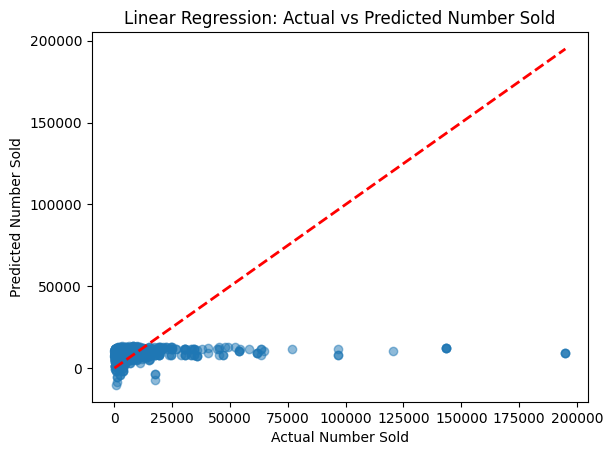

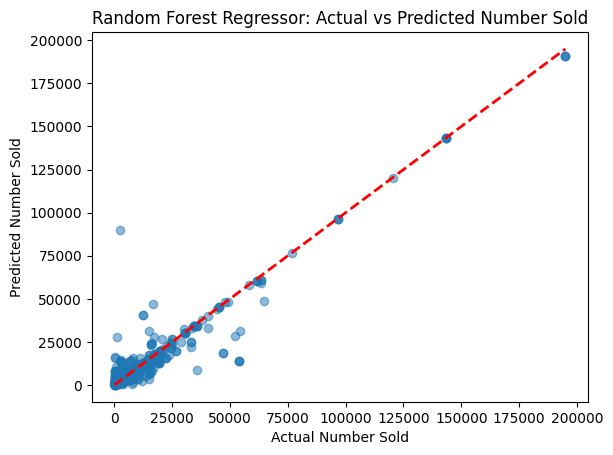

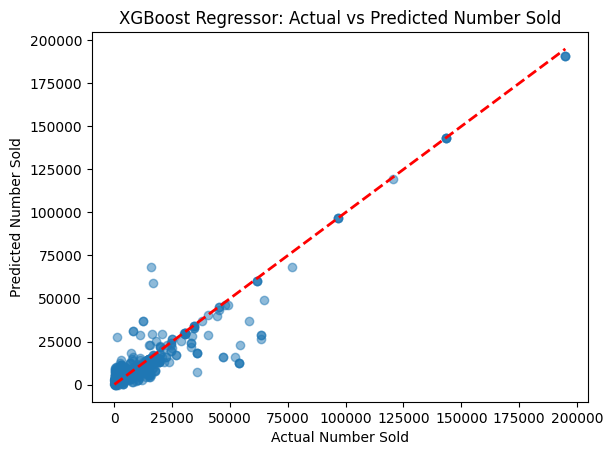

In [25]:
# Actual prediction vs predicted plot for the best model
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Number Sold")
    plt.ylabel("Predicted Number Sold")
    plt.title(f"{model_name}: Actual vs Predicted Number Sold")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
    plt.show()

plot_actual_vs_predicted(y_test, pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, pred_rf, "Random Forest Regressor")
plot_actual_vs_predicted(y_test, pred_xgb, "XGBoost Regressor")

Feature Importance

In [26]:
print("\nFeature Importance for Random Forest Regressor:")
for name, importace in zip(x.columns, RFR.feature_importances_):
    print(f"{name}: {importace}")


Feature Importance for Random Forest Regressor:
price: 0.7359461215580535
overall rating: 0.11350156348158442
sentiment: 0.011258614820884246
salary: 0.1392937001394779


In [27]:
from sklearn.inspection import permutation_importance
result_RFR = permutation_importance(LR, x_test, y_test, n_repeats=10, random_state=42)
print("\nPermutation Importance for Linear Regression:")
for name, importance in zip(x.columns, result_RFR.importances_mean):
    print(f"{name}: {importance}")

print("\nFeature Importance for XGBoost Regressor:")
for name, importance in zip(x.columns, XGB.feature_importances_):
    print(f"{name}: {importance}")


Permutation Importance for Linear Regression:
price: 0.028126830543617552
overall rating: 0.00962125062370317
sentiment: 0.0240680064721411
salary: 0.0010201096820962375

Feature Importance for XGBoost Regressor:
price: 0.44894474744796753
overall rating: 0.2204136699438095
sentiment: 0.043401509523391724
salary: 0.2872401475906372


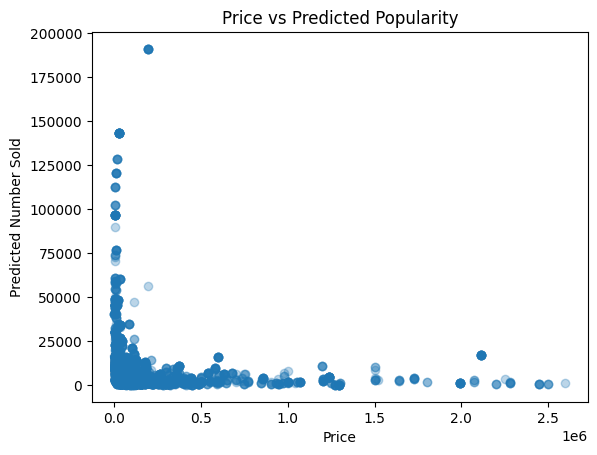

In [28]:
# Finding the optimal price ranges using the dataset, by plotting the prices vs predicted number sold
data["predicted sold"] = RFR.predict(x)
plt.scatter(data["price"], data["predicted sold"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Predicted Number Sold")
plt.title("Price vs Predicted Popularity")
plt.show()

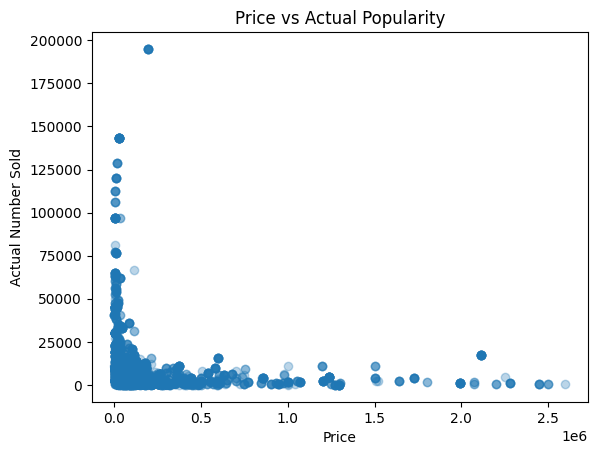

In [29]:
plt.scatter(data["price"], data["number sold"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Actual Number Sold")
plt.title("Price vs Actual Popularity")
plt.show()

In [30]:
from statsmodels.nonparametric.smoothers_lowess import lowess

data_smooth = data[["price", "predicted sold"]].dropna().sort_values("price")
smooth = lowess(data_smooth["predicted sold"], data_smooth["price"], frac=0.12)

plt.plot(smooth[:,0], smooth[:,1])
plt.xlabel("Price")
plt.ylabel("Predicted Number Sold")
plt.title("Smoothed Demand Curve")
plt.show()


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
ideal_ranges = {}

for c in data["category"].unique():
    sub = data[data["category"] == c]
    thr = sub["predicted sold"].quantile(0.90)
    top = sub[sub["predicted sold"] >= thr]
    
    ideal_ranges[c] = (top["price"].min(), top["price"].max())

# Display formatted results
for category, (min_price, max_price) in ideal_ranges.items():
    print(f"{category}: {int(min_price)} ~ {int(max_price)}")


computers and laptops: 18000 ~ 699000
toys and hobbies: 4150 ~ 27000
food and drink: 5400 ~ 70000
office & stationery: 3650 ~ 35000
automotive: 1500 ~ 9000
animal care: 19500 ~ 29500
body care: 29100 ~ 29100
party supplies and craft: 349 ~ 110000
carpentry: 3300 ~ 3700
other products: 2000 ~ 10000
sport: 11000 ~ 59999
precious metal: 39100 ~ 39100
property: 8400 ~ 80000
tour and travel: 199000 ~ 749900
books: 4000 ~ 50000
kitchen: 3199 ~ 599000
electronics: 18370 ~ 90000
kids and baby fashion: 9000 ~ 9250
muslim fashion: 3345 ~ 13500
men's fashion: 8900 ~ 1500000
women's fashion: 15000 ~ 30500
movies and music: 29490 ~ 298500
gaming: 850 ~ 359000
phones and tablets: 18000 ~ 2114000
mother and baby: 31478 ~ 52500
camera: 12950 ~ 180000
beauty: 20000 ~ 125000
health: 30000 ~ 84000
household: 825 ~ 115000


In [ ]:
data

,category,product name,location,price,overall rating,number sold,total review,customer review,sentiment,region,salary,predicted sold
0,computers and laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,jakarta utara,53500,4.9,5449,2369,Alhamdulillah berfungsi dengan baik. Packaging...,1,dki jakarta,5396760.0,5475.54
1,computers and laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,tangerang selatan,72000,4.9,2359,1044,"barang bagus dan respon cepat, harga bersaing ...",1,banten,2905119.0,2450.54
2,computers and laptops,SSD Midasforce 128 Gb - Tanpa Caddy,jakarta barat,213000,5.0,12300,3573,"barang bagus, berfungsi dengan baik, seler ram...",1,dki jakarta,5396760.0,10660.53
3,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,bagus sesuai harapan penjual nya juga ramah. t...,1,dki jakarta,5396760.0,2074.22
4,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",1,dki jakarta,5396760.0,2074.22
...,...,...,...,...,...,...,...,...,...,...,...,...
5142,household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,jakarta pusat,35000,4.9,1431,562,"Harga bersaing, barang sesuai pesanan. Saya na...",1,dki jakarta,5396760.0,1424.10
5143,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,Beli ini krn Anak & Istri mau liburan di Jakar...,1,dki jakarta,5396760.0,15434.73
5144,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,"pengemasan barang baik, kondisi barang jg utuh...",1,dki jakarta,5396760.0,15434.73
5145,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,Mungil tapi bekerja dng baik. Dan murahh terja...,1,dki jakarta,5396760.0,15434.73


In [ ]:
# Calculate demand gaps per region
# Group by region and compare predicted vs actual demand
region_analysis = data.groupby("region").agg({
    "predicted sold": "mean",
    "number sold": "mean",
    "price": "mean"
}).reset_index()

region_analysis["demand_gap"] = region_analysis["number sold"] - region_analysis["predicted sold"]
region_analysis["gap_percentage"] = (region_analysis["demand_gap"] / region_analysis["predicted sold"]) * 100

# Sort by demand gap to identify biggest opportunities (negative = underperforming)
region_analysis = region_analysis.sort_values("demand_gap", ascending=False)

print("\nRegional Demand Gap Analysis:")
print(region_analysis.to_string(index=False))


Regional Demand Gap Analysis:
           region  predicted sold  number sold         price  demand_gap  gap_percentage
          lampung    25881.980000 33200.000000  18000.000000 7318.020000       28.274576
       jawa timur     6284.887432  6476.986486 146678.432432  192.099054        3.056523
 sumatera selatan    12140.085000 12191.527778  27680.555556   51.442778        0.423743
      dki jakarta     8206.141036  8239.200190 177962.835547   33.059154        0.402859
kalimantan tengah      410.830000   429.000000  37500.000000   18.170000        4.422754
             bali     2658.920833  2660.000000  26900.000000    1.079167        0.040587
    di yogyakarta     1940.359375  1939.937500  42481.250000   -0.421875       -0.021742
   sumatera utara     4196.490000  4173.000000  29000.000000  -23.490000       -0.559754
           banten     9555.051851  9517.943081 163926.448479  -37.108769       -0.388368
        kep. riau      493.460000   414.000000  90000.000000  -79.460000      -

In [ ]:
# Find ideal price ranges per location (similar to category analysis)
location_ranges = {}

for loc in data["location"].unique():
    sub = data[data["location"] == loc]
    thr = sub["predicted sold"].quantile(0.90)
    top = sub[sub["predicted sold"] >= thr]
    
    location_ranges[loc] = (top["price"].min(), top["price"].max())

# Display formatted results
print("Ideal Price Ranges by Location:")
for location, (min_price, max_price) in location_ranges.items():
    print(f"{location}: {int(min_price)} - {int(max_price)}")

Ideal Price Ranges by Location:
jakarta utara: 3500 - 699000
tangerang selatan: 7500 - 112000
jakarta barat: 349 - 110000
jakarta timur: 2850 - 79900
jakarta selatan: 176 - 85000
jakarta pusat: 850 - 2114000
bandung: 5400 - 48000
depok: 1500 - 65000
surabaya: 7999 - 64000
tangerang: 2000 - 599000
bekasi: 3300 - 19500
malang: 42000 - 46000
tegal: 6000 - 6000
batang: 59800 - 59800
bandar lampung: 18000 - 18000
cianjur: 16000 - 16000
palembang: 30500 - 30500
surakarta: 79499 - 79499
bogor: 2000 - 2000
sleman: 65800 - 65800
sidoarjo: 2000 - 2000
sukabumi: 43500 - 43500
semarang: 52500 - 52500
kediri: 27000 - 27000
tulungagung: 299900 - 299900
palangkaraya: 37500 - 37500
bandung barat: 50000 - 50000
tasikmalaya: 5750 - 90000
batam: 90000 - 90000
makassar: 50000 - 50000
pemalang: 15900 - 15900
sukoharjo: 2750 - 2750
cimahi: 15000 - 15000
pekalongan: 62900 - 62900
klaten: 22000 - 22000
denpasar: 26900 - 26900
serang: 125000 - 125000
mojokerto: 65000 - 65000
medan: 29000 - 29000


In [ ]:
# Detailed location-level analysis for the biggest gap regions
print("\n=== DETAILED LOCATION ANALYSIS ===")
top_gap_regions = region_analysis.head(3)["region"].values

for reg in top_gap_regions:
    print(f"\n--- {reg} ---")
    loc_data = data[data["region"] == reg].groupby("location").agg({
        "predicted sold": "mean",
        "number sold": "mean",
        "price": "mean"
    }).reset_index()
    
    loc_data["demand_gap"] = loc_data["number sold"] - loc_data["predicted sold"]
    loc_data = loc_data.sort_values("demand_gap", ascending=False)
    print(loc_data.to_string(index=False))


=== DETAILED LOCATION ANALYSIS ===

--- lampung ---
      location  predicted sold  number sold   price  demand_gap
bandar lampung        25881.98      33200.0 18000.0     7318.02

--- jawa timur ---
   location  predicted sold  number sold         price  demand_gap
   surabaya     5837.340106  6151.510638 129853.276596  314.170532
     kediri     8963.694375  8984.375000  23512.500000   20.680625
   sidoarjo    14879.641429 14885.857143 123142.857143    6.215714
tulungagung      326.000000   326.000000 299900.000000    0.000000
  mojokerto     3191.570000  3156.000000  65000.000000  -35.570000
     malang     1534.960909  1406.545455 382545.454545 -128.415455

--- sumatera selatan ---
 location  predicted sold  number sold        price  demand_gap
palembang       12140.085 12191.527778 27680.555556   51.442778


In [ ]:
region_analysis

,region,predicted sold,number sold,price,demand_gap,gap_percentage
9,lampung,25881.980000,33200.000000,18000.000000,7318.020000,28.274576
6,jawa timur,6284.887432,6476.986486,146678.432432,192.099054,3.056523
11,sumatera selatan,12140.085000,12191.527778,27680.555556,51.442778,0.423743
3,dki jakarta,8206.141036,8239.200190,177962.835547,33.059154,0.402859
7,kalimantan tengah,410.830000,429.000000,37500.000000,18.170000,4.422754
0,bali,2658.920833,2660.000000,26900.000000,1.079167,0.040587
2,di yogyakarta,1940.359375,1939.937500,42481.250000,-0.421875,-0.021742
12,sumatera utara,4196.490000,4173.000000,29000.000000,-23.490000,-0.559754
1,banten,9555.051851,9517.943081,163926.448479,-37.108769,-0.388368
8,kep. riau,493.460000,414.000000,90000.000000,-79.460000,-16.102622


In [ ]:
# Identify specific regions with supply gaps or pricing mismatches
print("\n=== REGIONS OVERPERFORMING (Actual > Predicted) ===")
overperforming = region_analysis[region_analysis["demand_gap"] > 0]
print(overperforming[["region", "demand_gap", "gap_percentage", "price"]].to_string(index=False))

print("\n=== REGIONS UNDERPERFORMING (Actual < Predicted) ===")
underperforming = region_analysis[region_analysis["demand_gap"] < 0]
print(underperforming[["region", "demand_gap", "gap_percentage", "price"]].to_string(index=False))


=== REGIONS OVERPERFORMING (Actual > Predicted) ===
           region  demand_gap  gap_percentage         price
          lampung 7318.020000       28.274576  18000.000000
       jawa timur  192.099054        3.056523 146678.432432
 sumatera selatan   51.442778        0.423743  27680.555556
      dki jakarta   33.059154        0.402859 177962.835547
kalimantan tengah   18.170000        4.422754  37500.000000
             bali    1.079167        0.040587  26900.000000

=== REGIONS UNDERPERFORMING (Actual < Predicted) ===
          region  demand_gap  gap_percentage         price
   di yogyakarta   -0.421875       -0.021742  42481.250000
  sumatera utara  -23.490000       -0.559754  29000.000000
          banten  -37.108769       -0.388368 163926.448479
       kep. riau  -79.460000      -16.102622  90000.000000
      jawa barat  -80.864733       -0.725629  67606.355126
sulawesi selatan -110.300000       -4.536668  50000.000000
     jawa tengah -173.684776       -3.963044  47327.597015


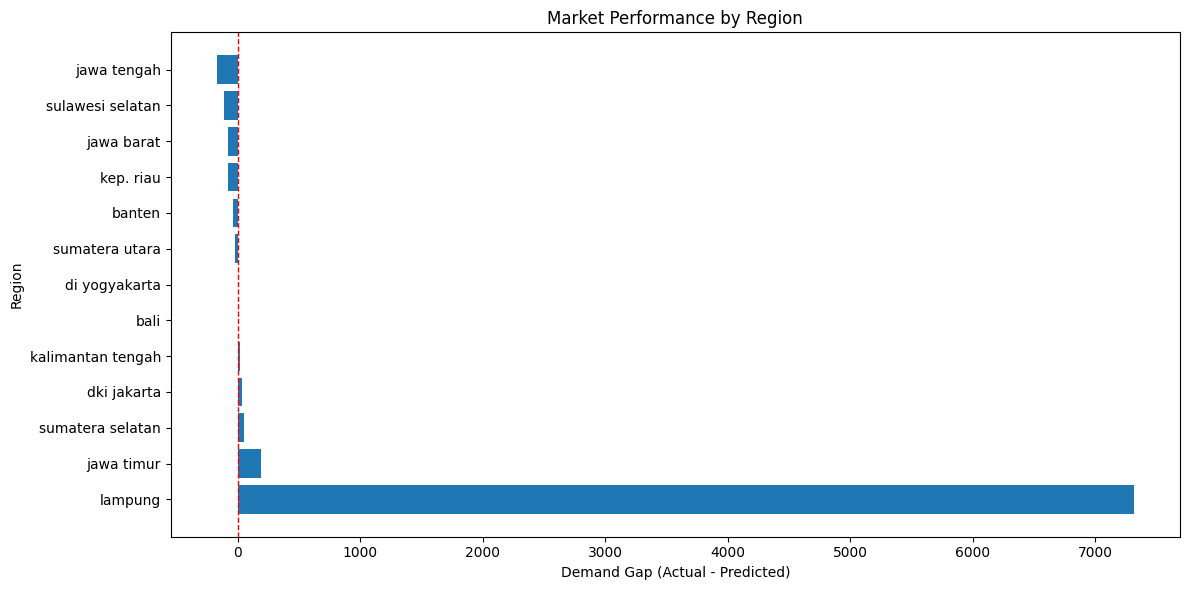

In [ ]:
# Visualize demand gaps by region
plt.figure(figsize=(12, 6))
plt.barh(region_analysis["region"], region_analysis["demand_gap"])
plt.xlabel("Demand Gap (Actual - Predicted)")
plt.ylabel("Region")
plt.title("Market Performance by Region")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Positive gap = Overperforming (actual sales > predicted)
# Negative gap = Underperforming (actual sales < predicted)

TUNING OUR BEST PERFORMING MACHINE LEARNING MODEL: STILL ON PROGRESS!

In [ ]:
# Use randomized search CV to tune the Random Forest Classifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RF,
    param_distributions=param_grid,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(x_train, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best CV Accuracy:", rf_random.best_score_)

NameError: name 'RF' is not defined

In [ ]:
rf_best = rf_random.best_estimator_
test_pred = rf_best.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

Although we already tuned this to the best settings, it is still not a good model accuracy, therefore we could see that we are still lacking with the features. Now it's time to add more features such as categorical features or even the 'customer review' (the comment from the customer in text form of that particular product). 

We proceed with vectorizing the text file to become numerical. Let's use OneHotEncoder for our categorical features, and using TF-IDF vectorizer for the customer review text (Interesting Note: Since tokopedia comments are in the Indonesian language we use the libarary Sastrawi in order to get the indonesian stop words to then be used by TF-IDF)! 

In [ ]:
# Use this libary for combing the numerical features with the categorical features
from sklearn.compose import ColumnTransformer

# This one is for the categorical features = [category, region]
from sklearn.preprocessing import OneHotEncoder

# This one is for the purely text feature (all suppose to be unique text data) = customer review
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Get the indonesian stop words
stop_words_ind = StopWordRemoverFactory().get_stop_words()

from sklearn.pipeline import Pipeline

In [ ]:
numerical_features = ["price", "overall rating", "number sold", "total review", "salary"]
categorical_features = ["category", "region"] 
text_features = "customer review"

In [ ]:
X = data[numerical_features + categorical_features + [text_features]]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=5000,
            stop_words=stop_words_ind,
            ngram_range=(1,2),
            sublinear_tf=True
        ), text_features),
        
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        
        ("num", "passthrough", numerical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_best)
])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=432
)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Final Model with Text + Categorical Features Accuracy:",
      accuracy_score(Y_test, y_pred))

print(classification_report(Y_test, y_pred))

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    Y_test,
    display_labels=model.named_steps["classifier"].classes_,
    cmap="Blues",
    xticks_rotation="horizontal"
)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Prediction distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

In [ ]:
unique, counts = np.unique(Y_test, return_counts=True)
print("True label distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")